In [1]:
run load_libs.py

<IPython.core.display.Javascript object>

Pinball loss is commonly used in [quantile
regression](https://en.wikipedia.org/wiki/Quantile_regression).

Definition:


\begin{align}
\mathbb{E}[L_{\tau}]
&= \iint (t - y(\mathbf{x})) (\tau - \mathbb{I}_{t < y(\mathbf{x})}) p(\mathbf{x}, t) d\mathbf{x} dt
\end{align}

To minimize it, we first calculate the derviative wrt. $y(\mathbf{x})$,

\begin{align}
\frac{\partial \mathbb{E}[L_{\tau}]}{\partial y(\mathbf{x})}
&= - \int (\tau - \mathbb{I}_{t < y(\mathbf{x})}) p(\mathbf{x}, t) dt \\
&= - \int_{-\infty}^{y(\mathbf{x})} (\tau - 1) p(\mathbf{x}, t) dt - \int_{y(\mathbf{x})}^{\infty} \tau p(\mathbf{x}, t) dt \\
&= - \int_{-\infty}^{y(\mathbf{x})} (\tau - 1) p(t|\mathbf{x}) p(\mathbf{x}) dt - \int_{y(\mathbf{x})}^{\infty} \tau p(t|\mathbf{x}) p(\mathbf{x})  dt \\
\end{align}

then set the derivative to zero,

\begin{align}
(\tau - 1) \int_{-\infty}^{y(\mathbf{x})} p(t|\mathbf{x}) d\mathbf{x} + \tau \int_{y(\mathbf{x})}^{\infty}  p(t|\mathbf{x}) d\mathbf{x}
&= 0 \\
(\tau - 1) F_{t|\mathbf{x}}(y(\mathbf{x}))
&= - \tau (1 - F_{t|\mathbf{x}}(y(\mathbf{x}))) \\
F_{t|\mathbf{x}}(y(\mathbf{x})) &= \tau \\
y(\mathbf{x}) &= F_{t|\mathbf{x}}^{-1}(\tau)
\end{align}

Note,

* $\tau \in [0, 1]$.
* $F$ represents a CDF.

So when minimizing the pinball loss, the model is also trying to predict the
conditional $\tau$-th quantile of $t$ given $\mathbf{x}$, i.e.
$F_{t|\mathbf{x}}^{-1}(\tau)$.

Note, when $\tau = 0.5$, pinball loss become equilvalent to MAE scaled by 2, and
both are trying to predict the conditional median.

# Visualization

In [2]:
def pinball_loss(y, t, tau):
    return (t - y) * (tau - (t < y).astype(int))

In [3]:
dfs = []
t = 0
ys = np.arange(-10, 11, 1)
for tau in [0, 0.25, 0.5, 0.75, 1]:
    dfs.append(
        pd.DataFrame(
            {
                "delta": ys,
                "pinball_loss": pinball_loss(ys, t, tau),
                "τ": tau,
            }
        )
    )
ndf = pd.concat(dfs)

alt.Chart(ndf).mark_line().encode(
    x=alt.X("delta",  title="Δ = y(x) - t"),
    y="pinball_loss",
    color="τ:O",
)

alt.Chart(...)

Visualize in separate panels

In [4]:
alt.Chart(ndf).mark_line().encode(
    x=alt.X("delta", title="Δ = y(x) - t"),
    y="pinball_loss",
).properties(width=120, height=60).facet(facet="τ:O", columns=11)

alt.FacetChart(...)

The following chart shows the angle between two slopes for different τ values.

Note,

* when $y(\mathbf{x}) > t$, the slope is $1 - \tau$,
* when $y(\mathbf{x}) < t$, the slope is $- \tau$.

So the angle between two slopes is $180 - [(180 - \arctan(-\tau)) + \arctan(1 - \tau) ]$.

In [5]:
taus = np.arange(0, 1.1, 0.1)

def radian2degree(r):
    return r / np.pi * 180


alt.Chart(
    pd.DataFrame(
        {
            "τ": taus,
            "degree": 180 - radian2degree(np.pi - np.arctan(-taus) + np.arctan(1 - taus)),
        }
    )
).mark_line(point=True).encode(x='τ', y=alt.Y('degree', scale=alt.Scale(zero=False)))

alt.Chart(...)

The key observation is that the angle between slopes doesn't change in a linear rate as $\tau$ increases.

# Maximum likelihood interpretation

The corresponding likelihood distribution of Pinball loss is the so-called asymmetric Laplace distribution (ALD), which can be written in two forms.

The first form is commonly seen in literature, e.g. from [Geraci, M., & Bottai, M. (2007). Quantile regression for longitudinal data using the asymmetric Laplace distribution. Biostatistics, 8(1), 140–154](https://doi.org/10.1093/biostatistics/kxj039), and more closely related to the form of pinball loss. It's written as

\begin{align*}
p(t| \mathbf{x}; \tau, \sigma) 
&= \frac{\tau(1 - \tau)}{ \sigma } \exp \left\{ -\frac{(t - y(\mathbf{x})) (\tau - \mathbb{I}(t < y(\mathbf{x})))}{\sigma} \right \}
\end{align*}

where

* $\tau \in [0, 1]$.
* $\sigma > 0$

when $t > y(\mathbf{x})$,

\begin{align*}
p(t| \mathbf{x}; \tau, \sigma) 
&= \frac{\tau(1 - \tau)}{ \sigma } \exp \left\{ - (t - y(\mathbf{x})) \frac{\tau}{\sigma} \right \}
\end{align*}

when $t < y(\mathbf{x})$,

\begin{align*}
p(t|\mathbf{x}, \tau, \sigma) 
&= \frac{\tau(1 - \tau)}{ \sigma } \exp \left\{ - ( y(\mathbf{x}) - t) \frac{1 - \tau}{\sigma} \right \}
\end{align*}

The second form is from the [Wikipedia page on the ALD](https://en.wikipedia.org/wiki/Asymmetric_Laplace_distribution),

\begin{align*}
p(t | \mathbf{x}, \lambda, \kappa) 
&= \frac{\lambda}{\kappa + 1 / \kappa} \exp \left \{ - (t - y(\mathbf{x})) \lambda s \kappa^{s} \right \} \\
\end{align*}

where

* $\lambda > 0$.
* $\kappa > 0$.
* $s = \text{sign}(t - y(\mathbf{x}))$.

when $t > y(\mathbf{x})$, then $s = 1$,

\begin{align*}
p(t | \mathbf{x}, \lambda, \kappa) 
&= \frac{\lambda}{\kappa + 1 / \kappa} \exp \left \{ - (x - y(\mathbf{x})) \lambda \kappa \right \} \\
\end{align*}

when $t < y(\mathbf{x})$, then $s = -1$,

\begin{align*}
p(t | \mathbf{x}, \lambda, \kappa) 
&= \frac{\lambda}{\kappa + 1 / \kappa} \exp \left \{ - (y(\mathbf{x}) - x) \frac{\lambda}{\kappa} \right \} \\
\end{align*}

Comparing the two forms, we obtain

\begin{align*}
\tau &= \frac{\kappa^2}{1 + \kappa^2} \\
\sigma &= \frac{\kappa}{\lambda (1 + \kappa^2)}
\end{align*}

Equivalently,

\begin{align*}
\kappa &= \sqrt{\frac{\tau}{1 - \tau}} \\
\lambda &= \frac{1}{\sigma} \sqrt{\tau (1 - \tau)}
\end{align*}

Next, we write down the mean and variane for both forms. They are equilvalent, but just parameterized differently.

Mean:

\begin{align*}
\mathbb{E}[t] &= y(\mathbf{x}) + \frac{1 - \kappa^2}{\lambda \kappa} \;\;\; &\text{Wikipedian form}\\
\mathbb{E}[t] &= y(\mathbf{x}) + \frac{1 - 2 \tau}{1 - \tau} \frac{\sigma}{\tau} \;\;\; &\text{Literature form}\\
\end{align*}

Variance:

\begin{align*}
\text{var}[t] &= \frac{1 + \kappa^4}{\lambda^2 \kappa^2} \;\;\; &\text{Wikipedian form} \\
\text{var}[t] &= \left( 1 + \frac{\tau^2}{(1 - \tau)^2} \right) \frac{\sigma^2}{ \tau^2} \;\;\; &\text{Literature form}\\
\end{align*}

Now, we plot the literature form of ALD for different $\tau$ values.

In [6]:
def asymmetric_laplace_wiki_form(t, y, λ, κ):
    """Just put here for future reference, NOT used at the moment."""
    sign = np.sign(t - y)
    return λ / (κ + 1 / κ) * np.exp( - (t - y) * λ * sign * κ ** sign)

def asymmetric_laplace_literature_form(t, y, τ, σ):
    return τ * (1 - τ) / σ * np.exp( - (t - y) * (τ - (t < y).astype(int)) / σ)

In [7]:
ts = np.arange(-6, 10, 0.1)
dfs = []
for tau in [0.25, 0.5, 0.75]:
    for sigma in [0.5, 1, 2]:
        dfs.append(
            pd.DataFrame(
                {
                    "t": ts,
                    "τ": tau,
                    "σ": sigma,
                    "density": asymmetric_laplace_literature_form(
                        ts,
                        y=0,
                        τ=tau,
                        σ=sigma,
                    ),
                }
            )
        )
ndf = pd.concat(dfs).reset_index()

In [8]:
alt.Chart(ndf).mark_line().encode(
    x=alt.X("t", title="t"),
    y="density",
    color="σ:O",
).properties(width=250, height=200).facet(facet="τ:N")

alt.FacetChart(...)

We also verify the correctness of my implementation of ALD by comparing it to the [scipy.stats.laplace_asymmetric](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace_asymmetric.html).

In [9]:
def sample_ald_with_scipy(
    y: float,
    kappa: float,
    lambda_: float,
    size: int,
):
    """Take a sample from asymmetric Laplace distribution with scipy.stats """
    return scipy.stats.laplace_asymmetric(
        loc=y,
        scale=1 / lambda_,
        kappa=kappa,
    ).rvs(size=size)

kappa=1.500, lambda_=3.000, tau=0.692, sigma=0.154


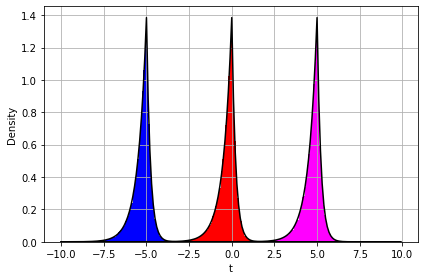

In [10]:
fig, ax = plt.subplots(1, 1)

kappa = 1.5
lambda_ = 3

# kappa = np.random.random() * 10  # sample from 0 to 10
# lambda_ = np.random.random() * 10  # sample from 0 to 10

tau = kappa ** 2 / (1 + kappa ** 2)
sigma = kappa / (lambda_ * (1 + kappa ** 2))

print(f"{kappa=:.3f}, {lambda_=:.3f}, {tau=:.3f}, {sigma=:.3f}")

ts = np.arange(-10, 10, 0.1)
for y_val, color in zip([-5, 0, 5], ["blue", "red", "magenta"]):

    sample = sample_ald_with_scipy(y_val, kappa, lambda_, size=50000)

    _ = ax.hist(sample, bins=100, density=True, color=color)

    ax.plot(
        ts,
        asymmetric_laplace_literature_form(ts, y=y_val, τ=tau, σ=sigma),
        color="black",
    )
    ax.grid()
    ax.set(xlabel="t", ylabel="Density")

plt.tight_layout()

Note the perfect match between the distributions of the sample from scipy.stats and `asymmetric_laplace_literature_form`, which confirms the correctness of our implementation.

Next, we compare the mean and variance between sample and population (theory).

In [11]:
# Take the last y_val, which correspond to the last sample.
last_y_val = y_val

Mean and variance from sample:

In [12]:
print(f"{np.mean(sample)=:}, {np.var(sample)=:}")

np.mean(sample)=4.723940151129943, np.var(sample)=0.299745227197759


Mean and variance from theory:

Wikipedian form:

In [13]:
# mean
last_y_val + (1 - kappa ** 2) / (lambda_ * kappa)

4.722222222222222

In [14]:
# variance
(1 + kappa ** 4) / (lambda_ ** 2 * kappa ** 2)

0.2993827160493827

Literature form:

In [15]:
# mean
last_y_val + (1 - 2 * tau) / ( 1 - tau) * sigma / tau

4.722222222222222

In [16]:
# var
(1 + tau ** 2 / (1 - tau) ** 2) * (sigma ** 2/ tau ** 2)

0.2993827160493827

As seen, the numbers calculated from the sample and theory match well.